# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's exisiting architecture and learned patterns for our own problem.

The two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

## Downloading and becoming one with the data

In [1]:
# Get data (10% of 10 food classes from Food 101)
import zipfile

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [2]:
# How many images in each folder?
import os

for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches

In [3]:
# Setup data inputs
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE=(224,224)
BATCH_SIZE=32

train_dir="10_food_classes_10_percent/train/"
test_dir="10_food_classes_10_percent/test/"

train_datagen=ImageDataGenerator(rescale=1/255.)
test_datagen=ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent=train_datagen.flow_from_directory(train_dir,
                                                        batch_size=BATCH_SIZE,
                                                        target_size=IMAGE_SHAPE,
                                                        class_mode="categorical")

print("Testing images:")
test_data_10_percent=test_datagen.flow_from_directory(test_dir,
                                                      batch_size=BATCH_SIZE,
                                                      target_size=IMAGE_SHAPE,
                                                      class_mode="categorical")

Testing images:
Found 750 images belonging to 10 classes.
Training images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [28]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch. Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub. 

We can access pre-trained models on [TFHub](https://tfhub.dev/)

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link for [efficientNet/b0/feature-vector](https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1)

In [15]:
# Let's compare the following two models
resnet_url="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url="https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [10]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [13]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [14]:
# Let's make a create_model() function to create a model from a URL

def create_model(model_url,num_classes=10):
    """
    Takes a TensorFlow Hub URL and create a Keras Sequential model with it.

    Args:
        model_url (str): A TensorFlow Hub feature extraction URL.
        num_classes (int): Number of output neurons in the output layer, should be equal to number of target classes
    
    Returns:
        An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neurons.
    """

    # Download the pretrained model and save it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False,
                                             name="feature_extractor_layer",
                                             input_shape=IMAGE_SHAPE+(3,)) # freeze the already learned patterns
    
    # Create our own model                                             
    model=tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes,activation="softmax",name="output_layer")
    ])

    return model

### Creating ResNet TensorFlow Hub Feature Extraction model

In [16]:
# Create ResNet model
resnet_model=create_model(resnet_url,num_classes=train_data_10_percent.num_classes)

In [17]:
# Let's see a summary of the model
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [18]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [29]:
# Fit the resnet model
resnet_history=resnet_model.fit(train_data_10_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_10_percent),
                                validation_data=test_data_10_percent,
                                validation_steps=len(test_data_10_percent),
                                callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                       experiment_name="resnet50V2",
                                                                       )])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220822-095526
Epoch 1/5
24/24 [==============================] - 17s 698ms/step - loss: 0.3194 - accuracy: 0.9373 - val_loss: 0.6535 - val_accuracy: 0.7808
Epoch 2/5
24/24 [==============================] - 16s 687ms/step - loss: 0.2708 - accuracy: 0.9560 - val_loss: 0.6484 - val_accuracy: 0.7824
Epoch 3/5
24/24 [==============================] - 16s 689ms/step - loss: 0.2313 - accuracy: 0.9587 - val_loss: 0.6384 - val_accuracy: 0.7836
Epoch 4/5
24/24 [==============================] - 16s 690ms/step - loss: 0.1973 - accuracy: 0.9760 - val_loss: 0.6323 - val_accuracy: 0.7900
Epoch 5/5
24/24 [==============================] - 16s 692ms/step - loss: 0.1693 - accuracy: 0.9840 - val_loss: 0.6216 - val_accuracy: 0.7928


Our transfer learning feature extractor model out performed ALL of the previous models we built by hand ... (substantially) and in quicker training time. This is only using 10% of the training examples

In [53]:
import matplotlib.pyplot as plt

# Plot the validation and training curves seperately
def plot_loss_curves(history):
  """
  Return seperate loss curves to evaluate different metrics
  """
  loss=history.history["loss"]
  val_loss=history.history["val_loss"]

  accuracy=history.history["accuracy"]
  val_accuracy=history.history["val_accuracy"]

  epochs=range(len(history.history["loss"])) # how many epochs 

  # Plot loss
  plt.plot(epochs,loss,label="training_loss")
  plt.plot(epochs,val_loss,label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label="training_accuracy")
  plt.plot(epochs,val_accuracy,label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

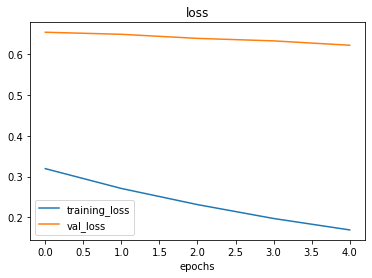

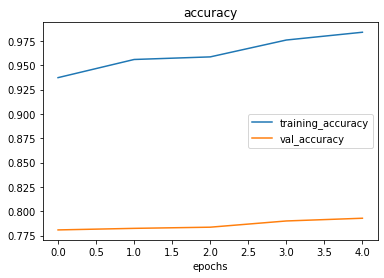

In [54]:
# Let's look at the loss curves
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlowHub Feature Extraction model

In [55]:
# Create EfficientNet model
efficientnet_model=create_model(efficientnet_url,num_classes=train_data_10_percent.num_classes)

In [56]:
# Summary of the EfficientNet model
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 1280)             4049564   
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [59]:
# Compile the model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])                           

In [60]:
# Fit the model 
efficientnet_history=efficientnet_model.fit(train_data_10_percent,
                                            epochs=5,
                                            steps_per_epoch=len(train_data_10_percent),
                                            validation_data=test_data_10_percent,
                                            validation_steps=len(test_data_10_percent),
                                            callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                   experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20220822-102941
Epoch 1/5
24/24 [==============================] - 30s 908ms/step - loss: 1.8066 - accuracy: 0.4560 - val_loss: 1.2791 - val_accuracy: 0.7432
Epoch 2/5
24/24 [==============================] - 12s 534ms/step - loss: 1.0397 - accuracy: 0.7947 - val_loss: 0.8470 - val_accuracy: 0.8252
Epoch 3/5
24/24 [==============================] - 12s 534ms/step - loss: 0.7397 - accuracy: 0.8387 - val_loss: 0.6828 - val_accuracy: 0.8512
Epoch 4/5
24/24 [==============================] - 12s 533ms/step - loss: 0.5968 - accuracy: 0.8733 - val_loss: 0.6004 - val_accuracy: 0.8592
Epoch 5/5
24/24 [==============================] - 12s 532ms/step - loss: 0.5023 - accuracy: 0.8987 - val_loss: 0.5497 - val_accuracy: 0.8644


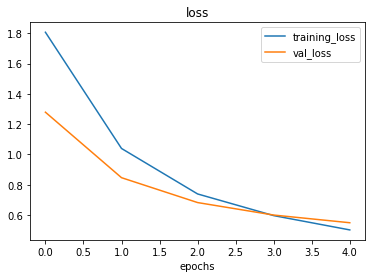

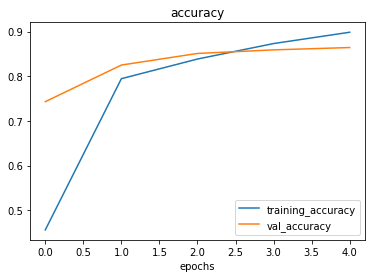

In [61]:
# Plot the loss curves
plot_loss_curves(efficientnet_history)

In [64]:
# How many layers does our efficientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes whatsoever (e.g. using ImageNet model on 1000 ImageNet classes)
* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on Image Net) and adjust the output layer for your own project
* **"Fine-tuning" transfer leraning**- use the prelearned patterns of an existing model and "fine-tune" many or all the underlying layers (including new output layers)

## Comparing our models results using TensorBoard

> **Note**: When you upload things to TensorBoard.dev, your experiments are public. So, if you're running private experiments do not upload them to TensorBoard.dev

Run these lines in the Anaconda Terminal:

Uploading results:
* `tensorboard dev upload --logdir ./tensorflow_hub/ --name "EfficientNet vs. ResNet --one_shot`

Listing results:
* `tensorboard dev list`

Deleting results:
* `tensorboard dev delete --experiment_id [INSERT_EXPERIMENT_ID_FOUND_USING_DEV_LIST]`